## Ascending input vs. descending input vs. combined ascending and descending input

In [1]:
import os
os.chdir('..')
from glob import glob
from notebooks import config
import numpy as np
import pandas as pd
import seaborn as sns
from utils.imgShow import imgShow, imsShow
import matplotlib.pyplot as plt
from utils.metrics_plot import csv_merge, smooth
from utils.metric import acc_matrix, acc_miou
from utils.raster_vec import vec2mask
from utils.geotif_io import readTiff
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import ListedColormap

In [2]:
### baseline: combined ascending and descending images
path_testsite_scene = glob(config.root_proj + '/data/dset/s1_as_des/*')
path_testsite_scene.sort()
path_testsite_truth = glob(config.root_proj + '/data/dset/s1_truth/*0?_wat*.tif')
path_testsite_truth.sort()
path_testsite_wats = glob(config.root_proj + '/data/dset/s1_water_test_gscales/*')
path_testsite_wats.sort()



### 1. Comparison among orbital data (plot smoothed metric for one test)

In [2]:
##### as -> 6: 87.3; des -> 7: 94.1; gscales -> 9: 95.5. -> 2: 95.4
####################################################################
## 1. Model name and the selected metric
model_name = ['gscales_as_test_6', 'gscales_des_test_7', 'model_gscales_test_2']

# metric_name = 'val_miou'
path_metrics_as = config.root_proj + '/model/pretrained/gscales_as_test/' + model_name[0] + '_metrics.csv'
path_metrics_des = config.root_proj + '/model/pretrained/gscales_des_test/' + model_name[1] + '_metrics.csv'
path_metrics_gscales = config.root_proj + '/model/pretrained/model_gscales_test/' + model_name[2] + '_metrics.csv'

## 2. Read metric file (each file corresponding to one model and contains all metrics)
metrics_as = pd.read_csv(path_metrics_as)
metrics_des = pd.read_csv(path_metrics_des)
metrics_gscales = pd.read_csv(path_metrics_gscales)
# metrics_as.tail()
metrics_gscales.tail()



,tra_loss,tra_miou,val_loss,val_miou
195,0.349358,0.910603,0.134667,0.954306
196,0.347194,0.922022,0.134665,0.954225
197,0.344734,0.936734,0.134472,0.954266
198,0.345163,0.928630,0.134314,0.954286
199,0.347060,0.918805,0.134277,0.954280


In [3]:
### metrics smooth
metrics_as_smooth_x, metrics_single_smooth_y = smooth(metrics_as['val_miou'].to_numpy(), num_sam=20)
metrics_des_smooth_x, metrics_scales_smooth_y = smooth(metrics_des['val_miou'].to_numpy(), num_sam=20)
metrics_gscales_smooth_x, metrics_gscales_smooth_y = smooth(metrics_gscales['val_miou'].to_numpy(), num_sam=20)


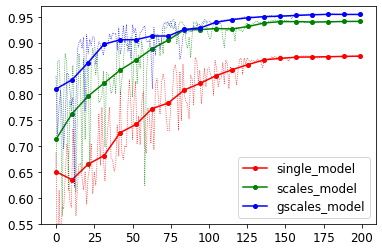

In [4]:
plt.rcParams.update({'font.size': 12})
color = ['red', 'green', 'blue']
plt.plot(metrics_as['val_miou'], color=color[0], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_as_smooth_x, metrics_single_smooth_y, color=color[0], \
            marker='o', markerfacecolor=color[0], markersize=4, linewidth=1.5, label= 'single_model')
plt.plot(metrics_des['val_miou'], color=color[1], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_des_smooth_x, metrics_scales_smooth_y, color=color[1], \
            marker='o', markerfacecolor = color[1], markersize=4, linewidth = 1.5,label= 'scales_model')

plt.plot(metrics_gscales['val_miou'], color=color[2], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_gscales_smooth_x, metrics_gscales_smooth_y, color=color[2], \
            marker='o', markerfacecolor=color[2], markersize=4, linewidth = 1.5, label= 'gscales_model')
plt.ylim(top=0.97, bottom=0.55)
plt.legend()


### 2. Comparison among orbital data (plot metric line with confidence interval)


In [5]:
### metrics path
dir_metric_gscales = config.root_proj + '/model/pretrained/model_gscales_test'
paths_metric_gscales = glob(dir_metric_gscales + '/*metrics*')
dir_metric_scales = config.root_proj + '/model/pretrained/model_scales_test'
paths_metric_scales = glob(dir_metric_scales + '/*metrics*')
dir_metric_single = config.root_proj + '/model/pretrained/model_single_test'
paths_metric_single = glob(dir_metric_single + '/*metrics*')


### Concat metrics obtained by different iteration

In [56]:
metrics_gscales = csv_merge(paths_metric_gscales, new_col='i_test', sam=1)
metrics_scales = csv_merge(paths_metric_scales, new_col='i_test', sam=1)
metrics_single = csv_merge(paths_metric_single, new_col='i_test', sam=1)
metrics_models = csv_merge([metrics_single, metrics_scales, metrics_gscales], new_col='i_model')

print(metrics_models.head())
print('gscales model: ',metrics_gscales.shape)
print('models:', metrics_models.shape)


   tra_loss  tra_miou  val_loss  val_miou  epoch  i_test  i_model
0  0.578091  0.575887  0.395957  0.507823      1       1        1
1  0.467392  0.688831  0.249648  0.831110      2       1        1
2  0.452648  0.731627  0.359461  0.534065      3       1        1
3  0.441382  0.724408  0.205774  0.814221      4       1        1
4  0.435599  0.746753  0.282407  0.672882      5       1        1
gscales model:  (2000, 6)
models: (6000, 7)


In [57]:
### change model name
metrics_models_ = metrics_models.rename(columns={'i_model': 'Model'})
metrics_models_['Model'] = metrics_models_['Model'].replace([1], 'Ascending image')
metrics_models_['Model'] = metrics_models_['Model'].replace([2], 'Descending image')
metrics_models_['Model'] = metrics_models_['Model'].replace([3], 'Combined as and des image')



### Plot epoch-val_miou figure.

Text(0, 0.5, 'Validation MIoU (%)')

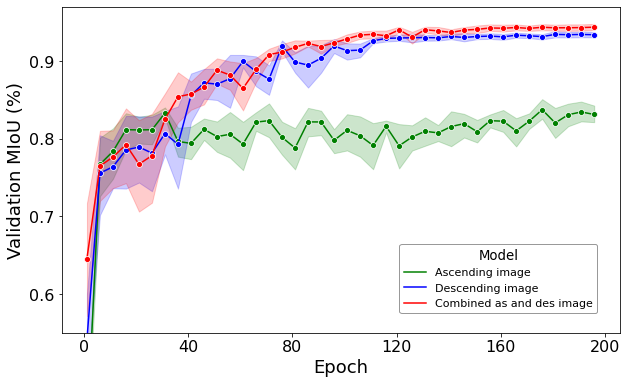

In [60]:
plt.rcParams.update({'font.size': 16})
colors = ['green', 'blue', 'red']

fig = plt.figure(figsize=(10,6))
ax_1 = fig.add_subplot(111)
sns.lineplot(data=metrics_models_[::5], x='epoch', y='val_miou', \
                hue='Model', palette=colors, marker='o', \
                ci=90, ax=ax_1)

# ax.legend().set_visible(False)
ax_1.legend(title ='Model', title_fontsize='small', edgecolor='0.5', \
          fontsize='x-small', loc='upper right', bbox_to_anchor=(0.47, -0.21, 0.5, 0.5))
ax_1.set_ylim(top=0.97, bottom=0.55)
y_major_locator=MultipleLocator(0.1)
ax_1.yaxis.set_major_locator(y_major_locator)
x_major_locator=MultipleLocator(40)
ax_1.xaxis.set_major_locator(x_major_locator)
ax_1.set_xlabel('Epoch', fontsize=18) 
ax_1.set_ylabel('Validation MIoU (%)', fontsize=18)
# plt.savefig(config.root_proj + '/figure/miou_methods_compare.png', bbox_inches='tight')


Text(0, 0.5, 'Validation MIoU (%)')

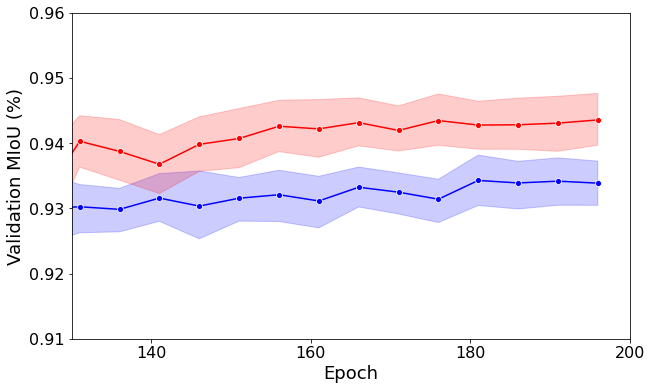

In [62]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_[::5], x='epoch', y='val_miou', \
                hue='Model', palette=colors, marker='o', \
                ci=90, ax=ax)

ax.legend().set_visible(False)
ax.set_ylim(top=0.96, bottom=0.91)
ax.set_xlim(left=130, right=200)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.01)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation MIoU (%)', fontsize=18)
# plt.savefig(config.root_proj + '/figure/miou_methods_compare.png', bbox_inches='tight')



### Plot epoch-val_loss figure.

Text(0, 0.5, 'Validation loss')

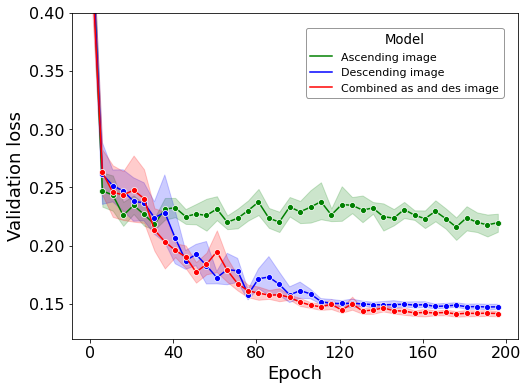

In [63]:
plt.rcParams.update({'font.size': 16})
colors = ['green', 'blue', 'red']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_[::5], x='epoch', y='val_loss', \
                hue='Model', palette=colors, marker='o', \
                ci=90, ax=ax)

# ax.legend().set_visible(False)
ax.legend(title ='Model', title_fontsize='small', edgecolor='0.5', \
          fontsize='x-small', loc='upper right', bbox_to_anchor=(0.48, 0.47, 0.5, 0.5))
ax.set_ylim(top=0.4, bottom=0.12)
x_major_locator=MultipleLocator(40)
y_major_locator=MultipleLocator(0.05)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation loss', fontsize=18)
# plt.savefig(config.root_proj + '/figure/loss_methods_compare.png', bbox_inches='tight')



Text(0, 0.5, 'Validation loss')

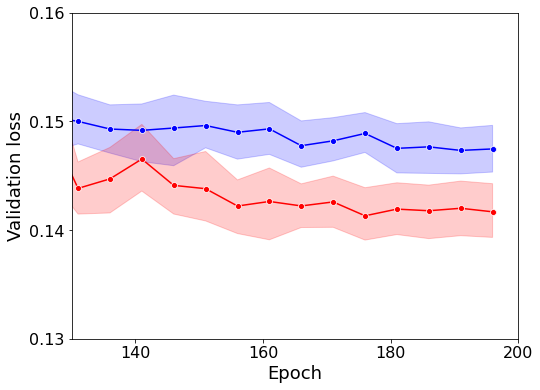

In [98]:
plt.rcParams.update({'font.size': 16})
colors = ['green', 'blue', 'red']
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_[::5], x='epoch', y='val_loss', \
                  hue='Model', palette=colors, marker='o', ci=90, ax=ax)
ax.legend().set_visible(False)
ax.set_xlim(left=130, right=200)
ax.set_ylim(top=0.16, bottom=0.13)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.01)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation loss', fontsize=18)
# plt.savefig(config.root_proj + '/figure/loss_methods_compare.png', bbox_inches='tight')



### Plot histogram

In [118]:
idx = metrics_models_['epoch']==200
metrics_models_epoch200 = metrics_models_[idx]
# metrics_models_epoch200

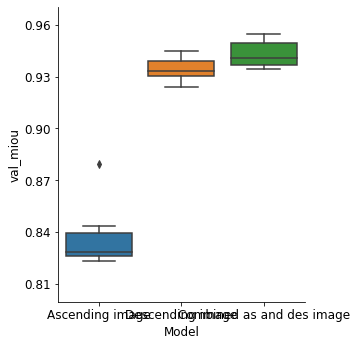

In [146]:
sns.catplot(data=metrics_models_epoch200, x= "Model", y = "val_miou", kind="box")
plt.ylim(bottom=0.8, top=0.97)
ax = plt.gca()
y_major_locator=MultipleLocator(0.03)
ax.yaxis.set_major_locator(y_major_locator)
# ax.get_xaxis().set_visible(False)


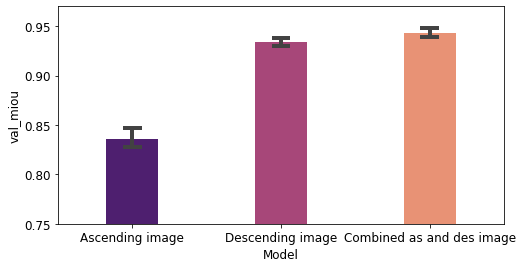

In [147]:
plt.rcParams.update({'font.size': 12})
def change_width(ax, new_width) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_width
        patch.set_width(new_width)
        patch.set_x(patch.get_x() + diff * .5)
plt.figure(figsize=(8,4))
ax = sns.barplot(data=metrics_models_epoch200, x= "Model", y = "val_miou", \
                  ci=95, capsize=.1, errwidth=4, palette='magma')                  
ax.set_ylim(bottom=0.75, top=0.97)
y_major_locator=MultipleLocator(0.05)
ax.yaxis.set_major_locator(y_major_locator)
change_width(ax, .35)


### **Visualize the results derived by methods**

In [31]:
path_testsite_s2 = glob(config.root_proj + '/data/dset/s2_img/*')
path_testsite_wats_as = glob(config.root_proj + '/data/dset/s1_water_test_des/s1as_*')
path_testsite_wats_des = glob(config.root_proj + '/data/dset/s1_water_test_des/s1des_*')
path_testsite_s2.sort()
path_testsite_s2 = path_testsite_s2[0:7]
path_testsite_wats_as.sort()
path_testsite_wats_des.sort()


In [35]:
scenes, truths = [], []
s2_scenes = []
wats, wats_des, wats_des_ = [], [], []
for idx in range(7):
    scene, scene_info = readTiff(path_testsite_scene[idx])
    s2_scene, s2_scene_info = readTiff(path_testsite_s2[idx])
    truth, truth_info = readTiff(path_testsite_truth[idx])
    wat, wat_info = readTiff(path_testsite_wats[idx])
    wat_as, wat_as_info = readTiff(path_testsite_wats_as[idx])
    wat_des, wat_des_info = readTiff(path_testsite_wats_des[idx])    
    scenes.append(scene); truths.append(truth)
    s2_scenes.append(s2_scene)
    wats.append(wat); wats_as.append(wat_as); wats_des.append(wat_des)


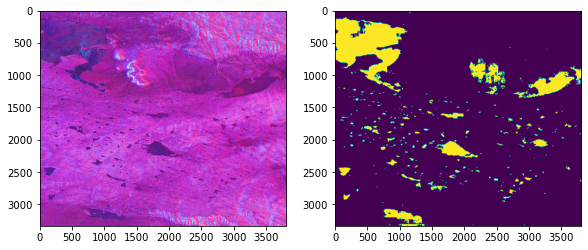

In [38]:
idx = 3
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
imgShow(scenes[idx])
plt.subplot(1,3,2)
imgShow(wats_as[idx])
plt.subplot(1,3,3)
imgShow(wats_des[idx])

